In [4]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from scipy.sparse.csgraph import laplacian
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [5]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
laplace_operator = laplacian(adjacency)
leadfield_smooth = leadfield @ abs(laplace_operator)

leadfield_smooth -= leadfield_smooth.mean(axis=0)
leadfield -= leadfield.mean(axis=0)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s


-- number of adjacent vertices : 1284


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]

Using control points [0.00000000e+00 0.00000000e+00 8.22122101e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


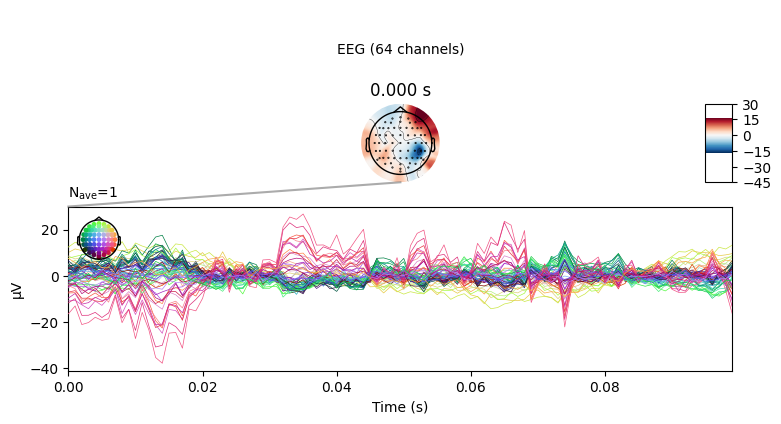

In [98]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=3, extents=(1, 30), duration_of_trial=0.1, target_snr=3)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint(times=[0,])

# Funs

In [86]:
def thresholding(x, k):
    ''' Set all but the k largest magnitudes in x to zero (0).

    Parameters
    ----------
    x : numpy.ndarray
        Data vector
    k : int
        The k number of largest magnitudes to maintain.

    Return
    ------
    x_new : numpy.ndarray
        Array of same length as input array x.
    '''
    if type(x) == list:
        x = np.array(x)
    highest_idc = np.argsort(abs(x))[-k:]
    # print(highest_idc)
    x_new = np.zeros(len(x))
    x_new[highest_idc] = x[highest_idc]
    return x_new

def euclidean_distance(A, B):
    ''' Euclidean Distance between two points.'''
    return np.sqrt(np.sum((A-B)**2))

def calc_area_tri(AB, AC, CB):
    ''' Calculates area of a triangle given the length of each side.'''
    
    s = (AB + AC + CB) / 2
    area = (s*(s-AB)*(s-AC)*(s-CB)) ** 0.5
    return area

def find_corner(source_power, residual):
    ''' Find the corner of the l-curve given by plotting regularization
    levels (r_vals) against norms of the inverse solutions (l2_norms).

    Parameters
    ----------
    r_vals : list
        Levels of regularization
    l2_norms : list
        L2 norms of the inverse solutions per level of regularization.
    
    Return
    ------
    idx : int
        Index at which the L-Curve has its corner.

    
    '''
    
    # Normalize l2 norms
    # source_power /= np.max(source_power)

    A = np.array([residual[0], source_power[0]])
    C = np.array([residual[-1], source_power[-1]])
    areas = []
    for j in range(1, len(source_power)-1):
        B = np.array([residual[j], source_power[j]])
        AB = euclidean_distance(A, B)
        AC = euclidean_distance(A, C)
        CB = euclidean_distance(C, B)
        area = abs(calc_area_tri(AB, AC, CB))
        areas.append(area)
    if len(areas) > 0:
        idx = np.argmax(areas)+1
    else:
        idx = 0
    return idx

# OMP-Like Patch Search

In [99]:
if len(y.shape)==2:
    y = y[:, 0]
y -= y.mean()
K = 1
n_chans = len(y)
_, n_dipoles = leadfield.shape
leadfield_smooth_normed = leadfield_smooth / leadfield_smooth.std(axis=0)

x_hat = np.zeros(n_dipoles)
x_hats = [deepcopy(x_hat)]
source_norms = np.array([0,])

x_hat = np.zeros((n_dipoles, ))
omega = np.array([])
r = deepcopy(y)
residuals = np.array([np.linalg.norm(y - leadfield@x_hat), ])
source_norms = np.array([0,])
x_hats = [deepcopy(x_hat), ]

for i in range(n_chans):
    b = leadfield_smooth_normed.T @ r
    b_thresh = thresholding(b, K)
    # omega = np.append(omega, np.where(b_thresh!=0)[0])  # non-zero idc
    new_patch = np.where(laplace_operator[b_thresh!=0][0]!=0)[0]
    omega = np.append(omega, new_patch)
    omega = omega.astype(int)
    # print(omega)
    x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @ y
    r = y - leadfield@x_hat

    residuals = np.append(residuals, np.linalg.norm(y - leadfield@x_hat))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    x_hats.append(deepcopy(x_hat))
    # if residuals[-1] > residuals[-2]:
    #     x_hat = x_hats[-2]
    #     break

    
iters = np.arange(len(residuals)).astype(float)

# Filter non-monotonic residuals
# bad_idc = np.where(np.diff(residuals)>0)[0]+1
# iters = np.delete(iters, bad_idc)
# x_hats = np.delete(np.stack(x_hats, axis=0), bad_idc, axis=0)
# residuals = np.delete(residuals, bad_idc)

bad_idx = (np.where(np.diff(residuals)>0)[0]+1)[0]
iters = iters[1:bad_idx]
x_hats = x_hats[1:bad_idx]
residuals = residuals[1:bad_idx]


corner_idx = find_corner(iters, residuals)
x_hat = x_hats[corner_idx]
# x_hat = x_hats[2]
plt.figure()
plt.plot(iters, residuals, '*k')
plt.plot(iters[corner_idx], residuals[corner_idx], 'or')


# Plot

Using control points [0.00000000e+00 0.00000000e+00 8.40835911e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


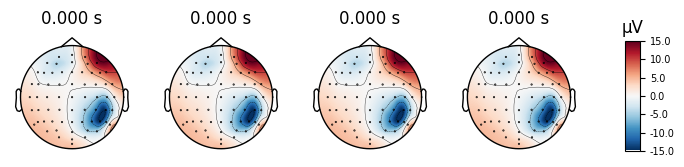

In [100]:
%matplotlib qt
stc_ = stc.copy()
stc_.data[:, 0] = x_hat / abs(x_hat).max()
# stc_.data = x_hat

brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Estimation', 'title',
               font_size=14)

eeg = leadfield @ x_hat
evoked = mne.EvokedArray(eeg[:, np.newaxis], info)
evoked.plot_topomap()

# OMP-like mixed search

In [101]:
if len(y.shape)==2:
    y = y[:, 0]
y -= y.mean()
K = 1
n_chans = len(y)
_, n_dipoles = leadfield.shape
leadfield_smooth_normed = leadfield_smooth / leadfield_smooth.std(axis=0)
leadfield_normed = leadfield / leadfield.std(axis=0)


x_hat = np.zeros(n_dipoles)
x_hats = [deepcopy(x_hat)]
source_norms = np.array([0,])

x_hat = np.zeros((n_dipoles, ))
omega = np.array([])
r = deepcopy(y)
residuals = np.array([np.linalg.norm(y - leadfield@x_hat), ])
source_norms = np.array([0,])
x_hats = [deepcopy(x_hat), ]

for i in range(n_chans):
    b_smooth = leadfield_smooth_normed.T @ r
    b_sparse = leadfield_normed.T @ r

    if abs(b_sparse).max() > abs(b_smooth).max():  # if sparse is better
        # print("Sparse is better")
        b_sparse_thresh = thresholding(b_sparse, K)
        new_patch = np.where(b_sparse_thresh != 0)[0]
        
    else: # else if patch is better
        # print("Smooth is better")
        b_smooth_thresh = thresholding(b_smooth, K)
        new_patch = np.where(laplace_operator[b_smooth_thresh!=0][0]!=0)[0]


    omega = np.append(omega, new_patch)
    omega = omega.astype(int)
    # print(omega)
    x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @ y
    r = y - leadfield@x_hat

    residuals = np.append(residuals, np.linalg.norm(y - leadfield@x_hat))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    x_hats.append(deepcopy(x_hat))
    # if residuals[-1] > residuals[-2]:
    #     x_hat = x_hats[-2]
    #     break

    
iters = np.arange(len(residuals)).astype(float)

# Filter non-monotonic residuals
# bad_idc = np.where(np.diff(residuals)>0)[0]+1
# iters = np.delete(iters, bad_idc)
# x_hats = np.delete(np.stack(x_hats, axis=0), bad_idc, axis=0)
# residuals = np.delete(residuals, bad_idc)
bad_idx = (np.where(np.diff(residuals)>0)[0]+1)[0]
iters = iters[1:bad_idx]
x_hats = x_hats[1:bad_idx]
residuals = residuals[1:bad_idx]



corner_idx = find_corner(iters, residuals)
x_hat = x_hats[corner_idx]
# x_hat = x_hats[2]
plt.figure()
plt.plot(iters, residuals, '*k')
plt.plot(iters[corner_idx], residuals[corner_idx], 'or')


# Plot

Using control points [0.00000000e+00 0.00000000e+00 8.29080357e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


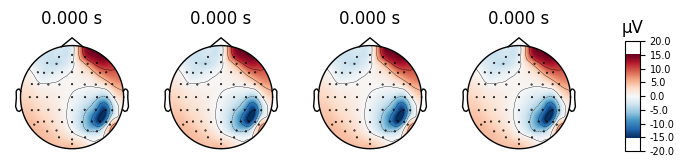

In [102]:
%matplotlib qt
stc_ = stc.copy()
stc_.data[:, 0] = x_hat / abs(x_hat).max()
# stc_.data = x_hat

brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Estimation', 'title',
               font_size=14)

eeg = leadfield @ x_hat
evoked = mne.EvokedArray(eeg[:, np.newaxis], info)
evoked.plot_topomap()